[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/biodatlab/deep-learning-skooldio/blob/master/03_handwritten_recognition_explore.ipynb)

## **Thai-digit handwritten classification with Pytorch: Exploration**

This notebook contains exploration of the "Thai-digit handwritten classification" including
- Customize model
    - Adding layers
    - Adding dropout layer
- Adding data augmentation

## **Download and clean the dataset from the repository**

- We have downloaded the data from https://github.com/kittinan/thai-handwriting-number by cloning the repository
- Remove files that have character mismatch (as suggested by the the creator)
- Then, we put the cleaned data at https://github.com/biodatlab/deep-learning-skooldio

In [1]:
!git clone https://github.com/biodatlab/deep-learning-skooldio

Cloning into 'deep-learning-skooldio'...
remote: Enumerating objects: 1877, done.
remote: Counting objects: 100% (1877/1877), done.
remote: Compressing objects: 100% (1820/1820), done.
remote: Total 1877 (delta 92), reused 1829 (delta 52), pack-reused 0
Receiving objects: 100% (1877/1877), 14.05 MiB | 14.61 MiB/s, done.
Resolving deltas: 100% (92/92), done.


In [2]:
import os
import os.path as op
from glob import glob
from pathlib import Path
import random
from PIL import Image
from collections import Counter

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms

In [5]:
directory = "deep-learning-skooldio/"
paths = glob(op.join(directory, "thai-handwritten-dataset", "*", "*"))
num_samples = len(paths)
print("Number of samples", num_samples)

Number of samples 1750


In [6]:
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import shutil

train_paths, test_paths = train_test_split(paths, test_size=0.1, random_state=42)
for i in range(10):
    os.makedirs(f"data/train/{i}", exist_ok=True)
    os.makedirs(f"data/validation/{i}", exist_ok=True)

In [7]:
def copy_to_destination(src_paths, dst_path: str = "data/train/"):
    for path in tqdm(src_paths):
        path = Path(path)
        if path.parent.name == "10":
            parent_dir = "0"
        else:
            parent_dir = path.parent.name
        shutil.copy(path, op.join(dst_path, parent_dir, path.name))

In [8]:
copy_to_destination(train_paths, "data/train/")
copy_to_destination(test_paths, "data/validation/")

  0%|          | 0/1575 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

## **Create a custom dataset and a dataloader**

In [49]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

In [50]:
# Create dataframe
train_df = pd.DataFrame({"path": glob("data/train/*/*")})
val_df = pd.DataFrame({"path": glob("data/validation/*/*")})

# Create text column from path
train_df["text"] = train_df["path"].apply(lambda x: int(Path(x).parent.name))
val_df["text"] = val_df["path"].apply(lambda x: int(Path(x).parent.name))

# Shape of dataframe
print("Number of train images = {}, number of validation images = {},".format(train_df.shape, val_df.shape))

Number of train images = (1575, 2), number of validation images = (175, 2),


In [51]:
class ThaiDigitDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.transform = transform
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        label = int(self.dataframe['text'][idx])
        image = Image.open(self.dataframe['path'][idx])
        if self.transform:
            image = 1 - self.transform(image)
        return image, label

In [52]:
train_thaidigit_dataset = ThaiDigitDataset(train_df, transform=transform)
val_thaidigit_dataset = ThaiDigitDataset(val_df, transform=transform)

In [53]:
train_loader = DataLoader(train_thaidigit_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_thaidigit_dataset, batch_size=16, shuffle=False)

## **Functions and utilities**

In [43]:
# Train function code from previous exercise
def train(model, n_epochs, loss_function, optimizer, train_loader, validation_loader, device):
    training_logs = {"train_loss": [],  "train_acc": [], "val_loss": [], "val_acc": []}
    print("-"*80)
    for epoch in range(1, n_epochs+1):
        # training
        model.train()
        train_loss, correct = 0, 0
        for images, labels in train_loader:
            pred = model(images)
            loss = loss_function(pred, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            correct += (pred.argmax(1) == labels).float().sum().item()
        # save training logs
        training_logs["train_loss"].append(train_loss/ len(train_loader))
        training_logs["train_acc"].append(correct / len(train_loader.dataset))

        # validation
        model.eval()
        val_loss, correct = 0, 0
        for images, labels in validation_loader:
            pred = model(images)
            val_loss += loss_function(pred, labels).item()
            correct += (pred.argmax(1) == labels).float().sum().item()
        # save validation logs
        training_logs["val_loss"].append(val_loss/ len(val_loader))
        training_logs["val_acc"].append(correct / len(validation_loader.dataset))

        print(f"Epochs {epoch}".ljust(10), 
              f"train loss {training_logs['train_loss'][-1]:.5f}",
              f"train acc {training_logs['train_acc'][-1]:.5f}",

              f"val loss {training_logs['val_loss'][-1]:.5f}",
              f"val acc {training_logs['val_acc'][-1]:.5f}",
              )
        print("-"*80)
    return model, training_logs
        

In [55]:
# evaluate function code from previous exercise
def evaluate(dataframe, model):
    model.eval()
    results = dataframe.copy()
    predictions = []
    for idx, row in results.iterrows():
        img = transform(Image.open(row.path))
        pred = model(1 - img)
        predictions.append(pred.argmax(1).item())

    results["prediction"] = predictions
    # Calculate accuracy
    accuracy = len(results[results.prediction == results.text]) / len(results)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    return results

In [54]:
def plot_graph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_acc"], label="Train")
    ax1.plot(history["val_acc"], label="Validation")
    ax1.legend()
    ax1.set_title("Accuracy")

    ax2.plot(history["train_loss"], label="Train")
    ax2.plot(history["val_loss"], label="Validation")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()

## **Create model**

Dropout is one of the techniques used to prevent overfitting

In [22]:
class DropoutThaiDigit(nn.Module):
    def __init__(self):
        super(DropoutThaiDigit, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(28*28, 392),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(392, 196),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(196, 98),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(98, 10),
        )

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        return self.layers(x)

## **Image Augmentation with CUDA**

Image augmentation is a technique used to artificially increase the size of a training dataset by creating modified versions of existing images.

In [14]:
# augment_transform is same as transform but add RandomAffine to the image

train_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.RandomAffine(degrees=(-15, 15), translate=(0.05, 0.1), scale=(1, 1)),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
])

In [15]:
example_augment_data = ThaiDigitDataset(train_df, transform=train_transform)
example_dataloader = DataLoader(example_augment_data, batch_size=16, shuffle=True)

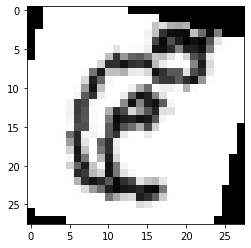

In [16]:
# Example of augmented image
img = (next(iter(example_dataloader))[0][1])
transformed_img = 1 - img

plt.imshow(transformed_img.squeeze(0), cmap="gray")
plt.show()

In [17]:
augmented_train_dataset = ThaiDigitDataset(train_df, transform=train_transform)
val_dataset = ThaiDigitDataset(val_df, transform=val_transform)

In [19]:
train_dataset = ConcatDataset([train_thaidigit_dataset, augmented_train_dataset])
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In this time we will train model using GPU (CUDA). <br /> We can check if cuda is available or not by using torch.cuda.is_available().

In [71]:
# Set device equal to cuda if available
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [74]:
n_epochs = 50
loss_fn = nn.CrossEntropyLoss()

augmented_model = DropoutThaiDigit()  # Initialize the model
augmented_model = augmented_model.to(device)

optimizer = torch.optim.SGD(augmented_model.parameters(), lr=0.01)

In [58]:
# Let's see what happens if we train the model with cuda
augmented_model, augmented_model_history = train(
    augmented_model, n_epochs, loss_fn, optimizer, train_dataloader, val_dataloader, device
)

--------------------------------------------------------------------------------


RuntimeError: ignored

There is a error in the code but why? <br />
Because the in train function, the data is not transfer to cuda device. <br />
So, we need to modify the train function to transfer the data to cuda device.

In [73]:
# Modify the train function to train with cuda.
# And this time we will save the model with the lowest validation loss.
def train_with_cuda(model, n_epochs, loss_function, optimizer, train_loader, validation_loader):
    training_logs = {"train_loss": [],  "train_acc": [], "val_loss": [], "val_acc": []}
    print("-"*80)
    for epoch in range(1, n_epochs+1):
        # training
        model.train()
        train_loss, correct = 0, 0
        for images, labels in train_loader:

            #!! Change device to cuda
            images = images.to("cuda")
            labels = labels.to("cuda") 
            pred = model(images)
            loss = loss_function(pred, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            correct += (pred.argmax(1) == labels).float().sum().item()
        # save training logs
        training_logs["train_loss"].append(train_loss/ len(train_loader))
        training_logs["train_acc"].append(correct / len(train_loader.dataset))

        # validation
        model.eval()
        val_loss, correct = 0, 0
        for images, labels in validation_loader:

            #!! Change device to cuda
            images = images.to("cuda")
            labels = labels.to("cuda") 
            pred = model(images)
            val_loss += loss_function(pred, labels).item()
            correct += (pred.argmax(1) == labels).float().sum().item()

        #!! Save best model
        # If training_logs["val_loss"] is not empty
        if len(training_logs["val_loss"]):
            # If the current validation loss is lower than the previous validation loss
            # So we save the model
            if min(training_logs["val_loss"]) > (val_loss/ len(val_loader)):
                save_path = "thai_digit.pth"
                torch.save(model.state_dict(), save_path)  # save model parameters
  
        # save validation logs
        training_logs["val_loss"].append(val_loss/ len(val_loader))
        training_logs["val_acc"].append(correct / len(validation_loader.dataset))

        print(f"Epochs {epoch}".ljust(10), 
              f"train loss {training_logs['train_loss'][-1]:.5f}",
              f"train acc {training_logs['train_acc'][-1]:.5f}",

              f"val loss {training_logs['val_loss'][-1]:.5f}",
              f"val acc {training_logs['val_acc'][-1]:.5f}",
              )
        print("-"*80)
    return model, training_logs

And the rest is the same as before

In [75]:
# Let's train the model with augmented data
augmented_model, augmented_model_history = train_with_cuda(
    augmented_model, n_epochs, loss_fn, optimizer, train_dataloader, val_dataloader
)

--------------------------------------------------------------------------------
Epochs 1   train loss 2.30558 train acc 0.09683 val loss 2.30042 val acc 0.10286
--------------------------------------------------------------------------------
Epochs 2   train loss 2.30358 train acc 0.09968 val loss 2.30063 val acc 0.09143
--------------------------------------------------------------------------------
Epochs 3   train loss 2.30155 train acc 0.11333 val loss 2.30038 val acc 0.08571
--------------------------------------------------------------------------------
Epochs 4   train loss 2.29986 train acc 0.11016 val loss 2.29956 val acc 0.09143
--------------------------------------------------------------------------------
Epochs 5   train loss 2.29790 train acc 0.11968 val loss 2.29834 val acc 0.10857
--------------------------------------------------------------------------------
Epochs 6   train loss 2.29566 train acc 0.15079 val loss 2.29619 val acc 0.15429
----------------------------

## **Error analysis**

In [78]:
# Load best model
model_path = "thai_digit.pth"
model = DropoutThaiDigit()  # initialize the model
model.load_state_dict(torch.load(model_path))  # load the model weights

<All keys matched successfully>

In [79]:
# Evaluate the new model with old dataset.
results = evaluate(val_df, model)

Accuracy: 74.29%


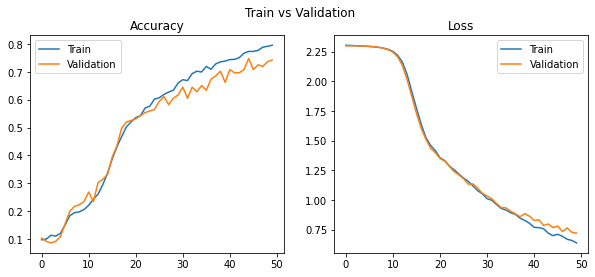

In [80]:
plot_graph(augmented_model_history)

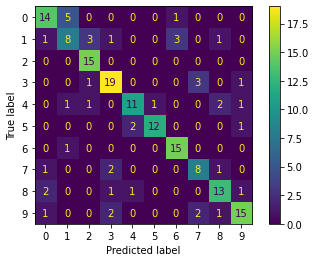

In [81]:
# Confusion matrix
cm = confusion_matrix(results.text, results.prediction, labels=range(10))
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
display.plot()
plt.show()